In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
import patsy

from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from pysal.model import mgwr
from mgwr.sel_bw import Sel_BW

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [3]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [4]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

<AxesSubplot:>

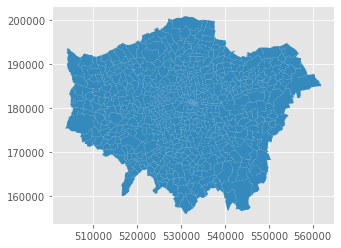

In [5]:
wards = gpd.read_file('data/London-wards-2018_ESRI/London_Ward.shp').to_crs('epsg:27700')
wards.plot()

<AxesSubplot:>

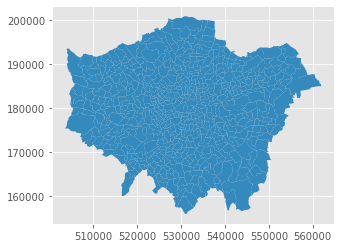

In [146]:
wards2 = gpd.read_file('data/statistical-gis-boundaries-london/ESRI/London_Ward_CityMerged.shp').to_crs('epsg:27700')
wards2.plot()

In [7]:
wards.head()

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.1730,0.0000,"POLYGON ((516401.596 160201.802, 516407.302 16..."
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.4640,0.0000,"POLYGON ((519552.998 164295.600, 519508.096 16..."
2,Berrylands,E05000401,Kingston upon Thames,E09000021,145.3900,0.0000,"POLYGON ((518107.499 167303.399, 518114.301 16..."
3,Alexandra,E05000400,Kingston upon Thames,E09000021,268.5060,0.0000,"POLYGON ((520336.700 165105.498, 520332.198 16..."
4,Beverley,E05000402,Kingston upon Thames,E09000021,187.8210,0.0000,"POLYGON ((521201.203 169275.505, 521204.303 16..."


In [157]:
access_public = pd.read_csv('data/access-public.csv', low_memory=False, 
                 usecols=['Ward','%_homes_access_to_open_space','Old ward code'])
print(f"Data frame is {access_public.shape[0]:,} x {access_public.shape[1]}")

Data frame is 626 x 3


In [158]:
air_pollution = pd.read_csv('data/air-pollution-mortality.csv', low_memory=False, encoding="ISO-8859-1",
                 usecols=['Area Code','PM_Concentration'])
print(f"Data frame is {air_pollution.shape[0]:,} x {air_pollution.shape[1]}")

Data frame is 626 x 2


In [160]:
air_pollution=air_pollution.rename(columns={'Area Code':'Old ward code'})

In [36]:
crime_rate = pd.read_csv('data/MPS_Ward_Level_Crime_Historic_NewWard.csv', low_memory=False, 
                 usecols=['WardCode','2011'])
print(f"Data frame is {crime_rate.shape[0]:,} x {crime_rate.shape[1]}")

Data frame is 20,126 x 2


In [37]:
crime_rate=crime_rate.rename(columns={'WardCode':'Ward'})

In [38]:
crime_rate = crime_rate.groupby('Ward')['2011'].agg('mean').reset_index() # msoa listings grouped price

In [39]:
crime_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ward    629 non-null    object 
 1   2011    629 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.0+ KB


In [17]:
road_case = pd.read_csv('data/road-casualties-severity-ward.csv', low_memory=False, 
                 usecols=['Ward Code','Total'])
print(f"Data frame is {road_case.shape[0]:,} x {road_case.shape[1]}")

Data frame is 627 x 2


In [25]:
road_case=road_case.rename(columns={'Ward Code':'Ward'})

In [18]:
walk_rate = pd.read_csv('data/travel-work-walk-census-2001-2011-ward.csv', low_memory=False, 
                 usecols=['Ward','2011;% travel by walk'])
print(f"Data frame is {walk_rate.shape[0]:,} x {walk_rate.shape[1]}")

Data frame is 661 x 2


In [93]:
ward = pd.read_csv('data/ward.csv', low_memory=False, 
                 usecols=['New Code','Air Emissions',' % Non Domestic Buildings','PTAL','Crime'])
print(f"Data frame is {ward.shape[0]:,} x {ward.shape[1]}")

Data frame is 628 x 5


In [94]:
ward=ward.rename(columns={'New Code':'Ward'})

In [161]:
new_df1 = pd.merge(access_public, air_pollution, on='Old ward code')
new_df1.head()
new_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 0 to 623
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ward                          624 non-null    object 
 1   Old ward code                 624 non-null    object 
 2   %_homes_access_to_open_space  624 non-null    float64
 3   PM_Concentration              624 non-null    float64
dtypes: float64(2), object(2)
memory usage: 24.4+ KB


In [96]:
new_df2 = pd.merge(new_df1, crime_rate, on='Ward',how='left')
new_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 0 to 623
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ward                          624 non-null    object 
 1   Old ward code                 624 non-null    object 
 2   %_homes_access_to_open_space  624 non-null    float64
 3   PM_Concentration              624 non-null    float64
 4   2011                          570 non-null    float64
dtypes: float64(3), object(2)
memory usage: 29.2+ KB


In [97]:
new_df3 = pd.merge(new_df2, road_case, on='Ward')
new_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 0 to 623
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ward                          624 non-null    object 
 1   Old ward code                 624 non-null    object 
 2   %_homes_access_to_open_space  624 non-null    float64
 3   PM_Concentration              624 non-null    float64
 4   2011                          570 non-null    float64
 5   Total                         624 non-null    object 
dtypes: float64(3), object(3)
memory usage: 34.1+ KB


In [98]:
new_df4 = pd.merge(new_df3, walk_rate, on='Ward')
new_df4.head()

,Ward,Old ward code,%_homes_access_to_open_space,PM_Concentration,2011,Total,2011;% travel by walk
0,E05000026,00ABFX,84.3000,15.3900,70.9688,52,0.8000
1,E05000027,00ABFY,15.7000,14.8600,29.4688,13,1.0000
2,E05000028,00ABFZ,42.5000,14.9400,36.1250,26,1.6000
3,E05000029,00ABGA,74.1000,14.8000,31.0312,63,1.2000
4,E05000030,00ABGB,39.3000,14.6600,24.6562,27,1.6000


In [99]:
new_df5 = pd.merge(new_df4, ward, on='Ward')
new_df5.head()

,Ward,Old ward code,%_homes_access_to_open_space,PM_Concentration,2011,Total,2011;% travel by walk,Air Emissions,% Non Domestic Buildings,PTAL,Crime
0,E05000026,00ABFX,84.3000,15.3900,70.9688,52,0.8000,53.7900,8.7203,5.8505,"2,186.0000"
1,E05000027,00ABFY,15.7000,14.8600,29.4688,13,1.0000,41.6900,2.7340,3.2588,873.0000
2,E05000028,00ABFZ,42.5000,14.9400,36.1250,26,1.6000,44.0000,3.4252,2.8520,"1,020.0000"
3,E05000029,00ABGA,74.1000,14.8000,31.0312,63,1.2000,39.4700,1.6629,2.2610,858.0000
4,E05000030,00ABGB,39.3000,14.6600,24.6562,27,1.6000,37.8300,4.7904,2.3297,691.0000


In [100]:
new_df5=new_df5.rename(columns={'%_homes_access_to_open_space':'Open_space_accessibility'})
new_df5=new_df5.drop(columns={'2011'})
new_df5=new_df5.rename(columns={'Total':'Road_cases'})
new_df5=new_df5.rename(columns={'2011;% travel by walk':'Walk_rate'})
new_df5=new_df5.rename(columns={'% Non Domestic Buildings':'Non-residential_proportion'})

In [101]:
new_df5=new_df5.drop(columns='Old ward code')

In [102]:
new_df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 0 to 623
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Ward                       624 non-null    object 
 1   Open_space_accessibility   624 non-null    float64
 2   PM_Concentration           624 non-null    float64
 3   Road_cases                 624 non-null    object 
 4   Walk_rate                  624 non-null    float64
 5   Air Emissions              624 non-null    float64
 6    % Non Domestic Buildings  624 non-null    float64
 7   PTAL                       624 non-null    float64
 8   Crime                      624 non-null    float64
dtypes: float64(7), object(2)
memory usage: 48.8+ KB


In [103]:
new_df5['Road_cases']=new_df5.Road_cases.astype('float')

In [104]:
new_df5.describe()

,Open_space_accessibility,PM_Concentration,Road_cases,Walk_rate,Air Emissions,% Non Domestic Buildings,PTAL,Crime
count,624.0000,624.0000,624.0000,624.0000,624.0000,624.0000,624.0000,624.0000
mean,54.1869,15.3386,45.4968,3.9082,52.1381,6.5084,3.6698,"1,215.9327"
std,23.0142,0.5518,34.5201,3.3798,11.6252,5.5489,1.3414,"1,134.8847"
min,1.3000,14.3600,1.0000,0.2000,30.6200,0.3882,1.2781,284.0000
25%,36.7000,14.9375,22.0000,1.3000,43.7300,2.7983,2.6225,738.7500
50%,53.7500,15.2450,38.0000,2.7500,49.9200,4.6827,3.2821,"1,020.0000"
75%,72.3000,15.6600,57.0000,5.8000,58.1650,8.7002,4.4540,"1,384.2500"
max,100.0000,17.7100,471.0000,19.1000,99.7000,42.1751,7.9594,"19,338.0000"


/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


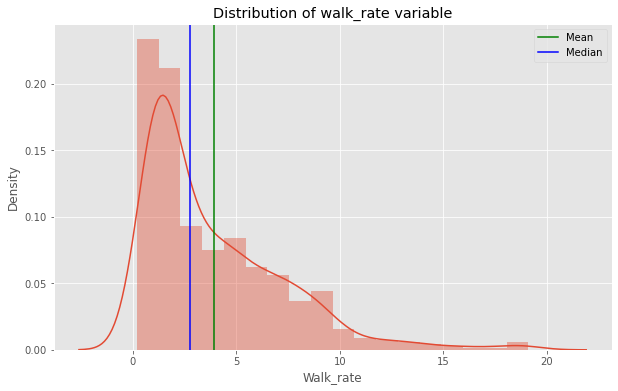

In [258]:
mean=new_df5['Walk_rate'].mean()
median=new_df5['Walk_rate'].median()
mode=new_df5['Walk_rate'].mode()
fig, ax = plt.subplots(figsize=(10,6)) # — — — — — — — — -Setting size of the canvas
sns.distplot(new_df5['Walk_rate'])
plt.title('Distribution of walk_rate variable')
plt.axvline(mean,color='green',label='Mean')
plt.axvline(median,color='blue',label='Median')
#plt.axvline(mode[0],color='red',label='Mode1')
#plt.axvline(mode[1],color='red',label='Mode2')
plt.legend()

In [260]:
fig.savefig('hisgraph.jpg', dpi=300)

                                          Open_space_accessibility  \
Open_space_accessibility                                    1.0000   
PM_Concentration                                            0.4302   
Road_cases                                                  0.0518   
Walk_rate                                                   0.2921   
Air Emissions                                               0.4206   
 % Non Domestic Buildings                                   0.3379   
PTAL                                                        0.3493   
Crime                                                       0.1834   

                                                  PM_Concentration  \
Open_space_accessibility                                    0.4302   
PM_Concentration                                            1.0000   
Road_cases                                                  0.3647   
Walk_rate                                                   0.5313   
Air Emissions      

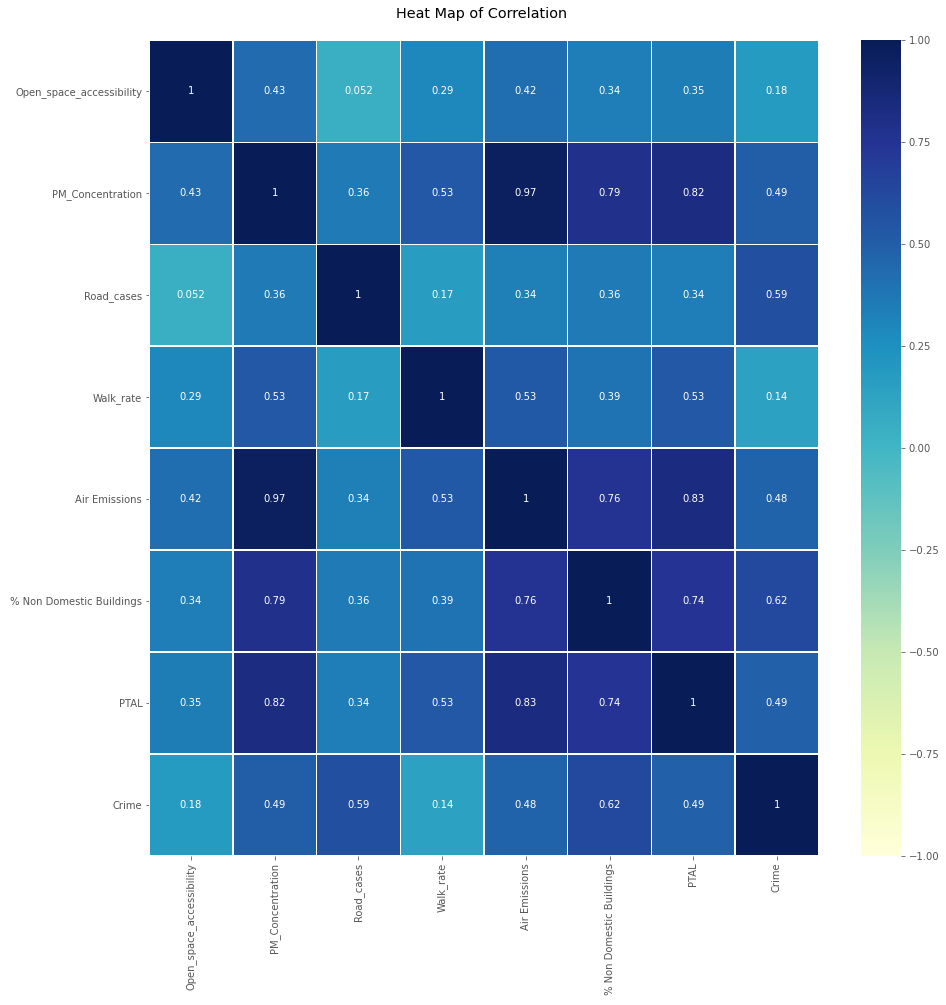

In [264]:
# # Pairplot using s
corr = new_df5.corr();
print(corr)
# sns.heatmap(corr, annot = True);
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
plt.title('Heat Map of Correlation \n')
sns.heatmap(corr,annot=True,cmap='YlGnBu',vmin=-1,vmax=1, linewidths=.5, center=0);

In [265]:
fig.savefig('correlation of variables.jpg', dpi=300)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/co

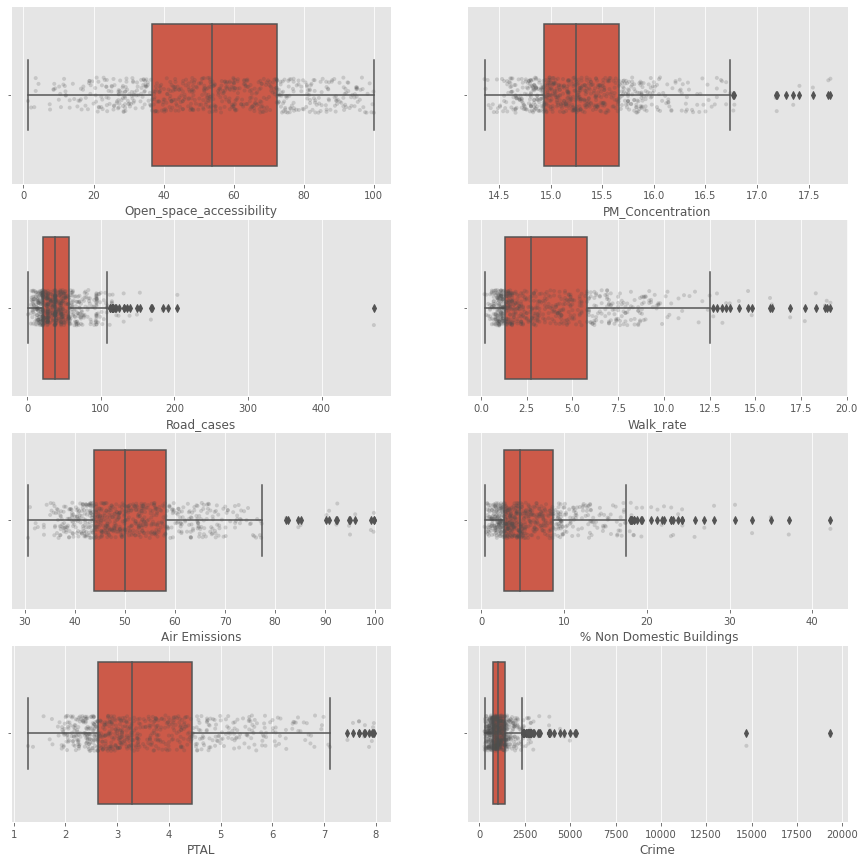

In [270]:
fi=plt.figure(figsize=(15,15))
pos = 1
for i in new_df5.drop(columns = {'Ward'}).columns:
 plt.subplot(4, 2, pos)
 sns.boxplot(new_df5[i])
 sns.stripplot(new_df5[i], data=new_df5,
              size=4, color=".3", linewidth=0,alpha=.2)
 pos += 1

In [271]:
fi.savefig('boxplot of variables.jpg', dpi=300)

In [108]:
OLS1=new_df5.drop(columns={'Ward'})

In [114]:
new_df5.to_csv('1.csv')

In [119]:
OLS=pd.read_csv('2.csv', low_memory=False, 
                 usecols=['Ward','Open_space_accessibility','log_of_Road_cases','log_of_Walk_rate','log_of_ % Non Domestic Buildings',
                         'log_of_PTAL','Air Emissions','log_of_Crime'])

In [120]:
OLS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ward                              624 non-null    object 
 1   Open_space_accessibility          624 non-null    float64
 2   Air Emissions                     624 non-null    float64
 3   log_of_Road_cases                 624 non-null    float64
 4   log_of_Walk_rate                  624 non-null    float64
 5   log_of_ % Non Domestic Buildings  624 non-null    float64
 6   log_of_PTAL                       624 non-null    float64
 7   log_of_Crime                      624 non-null    float64
dtypes: float64(7), object(1)
memory usage: 39.1+ KB


In [121]:
OLS1=OLS.drop(columns={'Ward'})

In [110]:
# calculating VIF
# This function is partially from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [123]:
df_predictors_selected_VIF = drop_column_using_vif_(OLS1.drop('log_of_Walk_rate', axis=1))
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

The columns remaining after VIF selection are:
Index(['Open_space_accessibility', 'Air Emissions', 'log_of_Road_cases',
       'log_of_ % Non Domestic Buildings', 'log_of_PTAL', 'log_of_Crime'],
      dtype='object')


In [124]:
model_ALL = sm.OLS(endog=OLS1[['log_of_Walk_rate']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_ALL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_of_Walk_rate   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     87.86
Date:                Mon, 18 Jan 2021   Prob (F-statistic):           1.86e-79
Time:                        14:32:38   Log-Likelihood:                -88.340
No. Observations:                 624   AIC:                             190.7
Df Residuals:                     617   BIC:                             221.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                0.4934      0.183      2.699      0.007       0.134       0.852
Open_space_accessibility             0.0017      0.001      3.235      0.001       0.001       0.003
Air Emissions                        0.0099      0.002      5.417      0.000       0.006       0.014
log_of_Road_cases                    0.0028      0.042      0.067      0.947      -0.080       0.086
log_of_ % Non Domestic Buildings     0.1939      0.057      3.420      0.001       0.083       0.305
log_of_PTAL                          0.8975      0.141      6.349      0.000       0.620       1.175
log_of_Crime                        -0.4281      0.073     -5.890      0.000      -0.571      -0.285
==============================================================================
Omnibus:                        0.430   Durbin-Watson:                   0.852
Prob(Omnibus):                  0.807   Jarque-Bera (JB):                0.535
Skew:                           0.003   Prob(JB):                        0.765
Kurtosis:                       2.857   Cond. No.                     1.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

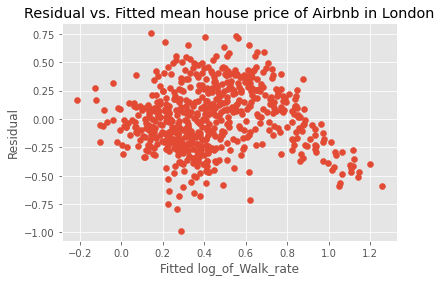

In [125]:
plt.scatter(model_ALL.fittedvalues, model_ALL.resid)
# adding title and labels
plt.xlabel('Fitted log_of_Walk_rate')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted mean house price of Airbnb in London')
plt.show()

In [126]:
OLS2=OLS1.drop(columns={'Open_space_accessibility','log_of_PTAL','Air Emissions','log_of_ % Non Domestic Buildings'})

In [129]:
df_predictors_selected_VIF = drop_column_using_vif_(OLS2.drop('log_of_Walk_rate', axis=1))
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

The columns remaining after VIF selection are:
Index(['log_of_Road_cases', 'log_of_Crime'], dtype='object')


In [130]:
model_safety = sm.OLS(endog=OLS2[['log_of_Walk_rate']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_safety.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_of_Walk_rate   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     29.70
Date:                Mon, 18 Jan 2021   Prob (F-statistic):           4.80e-13
Time:                        14:41:11   Log-Likelihood:                -252.52
No. Observations:                 624   AIC:                             511.0
Df Residuals:                     621   BIC:                             524.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.0271      0.190     -5.399      0.000      -1.401      -0.654
log_of_Road_cases    -0.0133      0.054     -0.246      0.806      -0.120       0.093
log_of_Crime          0.4923      0.070      7.034      0.000       0.355       0.630
==============================================================================
Omnibus:                       69.895   Durbin-Watson:                   0.563
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.904
Skew:                           0.002   Prob(JB):                     4.76e-05
Kurtosis:                       2.125   Cond. No.                         49.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
OLS3=OLS1.drop(columns={'Open_space_accessibility','log_of_PTAL','log_of_Road_cases','log_of_Crime'})

In [131]:
df_predictors_selected_VIF = drop_column_using_vif_(OLS3.drop('log_of_Walk_rate', axis=1))
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

The columns remaining after VIF selection are:
Index(['Air Emissions', 'log_of_ % Non Domestic Buildings'], dtype='object')


In [132]:
model_comfort = sm.OLS(endog=OLS3[['log_of_Walk_rate']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_comfort.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_of_Walk_rate   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     201.2
Date:                Mon, 18 Jan 2021   Prob (F-statistic):           4.41e-68
Time:                        14:42:20   Log-Likelihood:                -125.18
No. Observations:                 624   AIC:                             256.4
Df Residuals:                     621   BIC:                             269.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -0.5267      0.060     -8.756      0.000      -0.645      -0.409
Air Emissions                        0.0160      0.002     10.393      0.000       0.013       0.019
log_of_ % Non Domestic Buildings     0.1837      0.052      3.559      0.000       0.082       0.285
==============================================================================
Omnibus:                        1.931   Durbin-Watson:                   0.826
Prob(Omnibus):                  0.381   Jarque-Bera (JB):                1.776
Skew:                           0.039   Prob(JB):                        0.412
Kurtosis:                       2.751   Cond. No.                         303.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [128]:
OLS4=OLS1.drop(columns={'log_of_Road_cases','log_of_Crime','Air Emissions','log_of_ % Non Domestic Buildings'})

In [133]:
df_predictors_selected_VIF = drop_column_using_vif_(OLS4.drop('log_of_Walk_rate', axis=1))
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

The columns remaining after VIF selection are:
Index(['Open_space_accessibility', 'log_of_PTAL'], dtype='object')


In [134]:
model_convenient = sm.OLS(endog=OLS4[['log_of_Walk_rate']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_convenient.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_of_Walk_rate   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     202.3
Date:                Mon, 18 Jan 2021   Prob (F-statistic):           2.23e-68
Time:                        14:43:34   Log-Likelihood:                -124.50
No. Observations:                 624   AIC:                             255.0
Df Residuals:                     621   BIC:                             268.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.4576      0.046     -9.928      0.000      -0.548      -0.367
Open_space_accessibility     0.0026      0.001      4.779      0.000       0.002       0.004
log_of_PTAL                  1.3954      0.083     16.730      0.000       1.232       1.559
==============================================================================
Omnibus:                        0.175   Durbin-Watson:                   0.880
Prob(Omnibus):                  0.916   Jarque-Bera (JB):                0.275
Skew:                          -0.005   Prob(JB):                        0.871
Kurtosis:                       2.898   Cond. No.                         453.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
OLS=OLS.rename(columns={'Ward':'GSS_CODE'})

In [140]:
OLS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   GSS_CODE                          624 non-null    object 
 1   Open_space_accessibility          624 non-null    float64
 2   Air Emissions                     624 non-null    float64
 3   log_of_Road_cases                 624 non-null    float64
 4   log_of_Walk_rate                  624 non-null    float64
 5   log_of_ % Non Domestic Buildings  624 non-null    float64
 6   log_of_PTAL                       624 non-null    float64
 7   log_of_Crime                      624 non-null    float64
dtypes: float64(7), object(1)
memory usage: 39.1+ KB


In [147]:
wards2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        625 non-null    object  
 1   GSS_CODE    625 non-null    object  
 2   HECTARES    625 non-null    float64 
 3   NONLD_AREA  625 non-null    float64 
 4   LB_GSS_CD   625 non-null    object  
 5   BOROUGH     625 non-null    object  
 6   POLY_ID     625 non-null    int64   
 7   geometry    625 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 39.2+ KB


In [171]:
gwr_final=pd.merge(OLS, wards2,on='GSS_CODE',how="right")

In [179]:
gwr_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625 entries, 0 to 624
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   GSS_CODE                          625 non-null    object  
 1   Open_space_accessibility          625 non-null    float64 
 2   Air Emissions                     625 non-null    float64 
 3   log_of_Road_cases                 625 non-null    float64 
 4   log_of_Walk_rate                  625 non-null    float64 
 5   log_of_ % Non Domestic Buildings  625 non-null    float64 
 6   log_of_PTAL                       625 non-null    float64 
 7   log_of_Crime                      625 non-null    float64 
 8   NAME                              625 non-null    object  
 9   HECTARES                          625 non-null    float64 
 10  NONLD_AREA                        625 non-null    float64 
 11  LB_GSS_CD                         625 non-null    object  

In [175]:
gwr_final.at[gwr_final[gwr_final.log_of_Road_cases.isna()].index, 'Open_space_accessibility'] =90.2
gwr_final.at[gwr_final[gwr_final.log_of_Road_cases.isna()].index, 'Air Emissions'] =94.87
gwr_final.at[gwr_final[gwr_final.log_of_Road_cases.isna()].index, 'log_of_Walk_rate'] =0.72427587
gwr_final.at[gwr_final[gwr_final.log_of_Road_cases.isna()].index, 'log_of_ % Non Domestic Buildings'] =1.574074104
gwr_final.at[gwr_final[gwr_final.log_of_Road_cases.isna()].index, 'log_of_PTAL'] =0.885208685
gwr_final.at[gwr_final[gwr_final.log_of_Road_cases.isna()].index, 'log_of_Crime'] =3.744605875

In [177]:
gwr_final.at[gwr_final[gwr_final.log_of_Road_cases.isna()].index, 'log_of_Road_cases'] =0.84509804

In [178]:
gwr_final[gwr_final.log_of_Road_cases.isna()]

,GSS_CODE,Open_space_accessibility,Air Emissions,log_of_Road_cases,log_of_Walk_rate,log_of_ % Non Domestic Buildings,log_of_PTAL,log_of_Crime,NAME,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry


/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


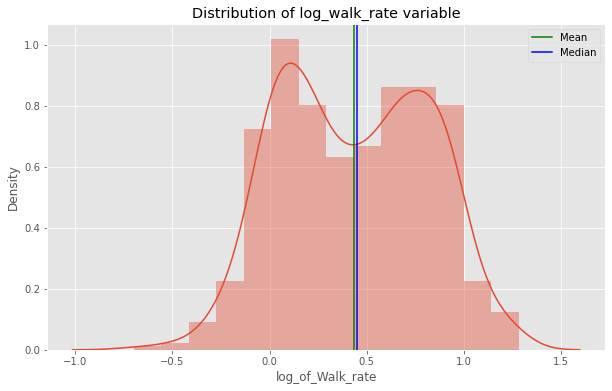

In [272]:
mean=gwr_final['log_of_Walk_rate'].mean()
median=gwr_final['log_of_Walk_rate'].median()
mode=gwr_final['log_of_Walk_rate'].mode()
fig, ax = plt.subplots(figsize=(10,6)) # — — — — — — — — -Setting size of the canvas
sns.distplot(gwr_final['log_of_Walk_rate'])
plt.title('Distribution of log_walk_rate variable')
plt.axvline(mean,color='green',label='Mean')
plt.axvline(median,color='blue',label='Median')
#plt.axvline(mode[0],color='red',label='Mode1')
#plt.axvline(mode[1],color='red',label='Mode2')
plt.legend()

In [273]:
fig.savefig('hisgraph_log.jpg', dpi=300)

In [180]:
GEO_final = gpd.GeoDataFrame(gwr_final)

<AxesSubplot:>

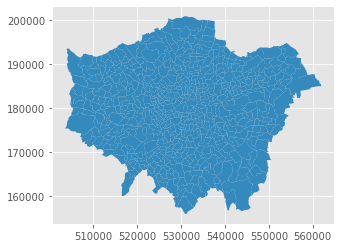

In [181]:
GEO_final.plot()

Text(0.05, 0.9, 'N')

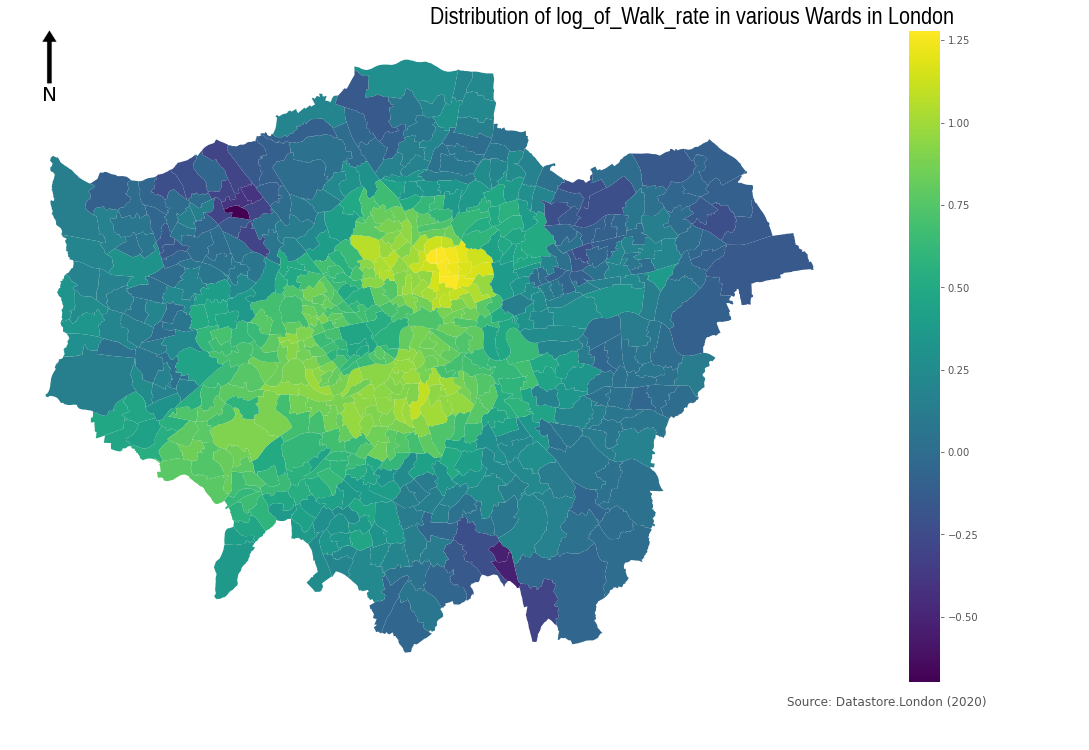

In [252]:
f,ax = plt.subplots(1,1,figsize=(20,12))

GEO_final.plot(column='log_of_Walk_rate', ax=ax, legend=True, cmap='viridis')
ax.axis('off')


ax.set_title('Distribution of log_of_Walk_rate in various Wards in London', ha='left',size=24, **tfont)


a = ax.annotate('Source: Datastore.London (2020)',
             xy=(0.905, 0.055), xycoords='figure fraction', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=12, fontweight=4, color='#555555') 
x, y, arrow_length = 0.05, 1, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


In [253]:
f.savefig('Distribution of walk rate(log).jpg', dpi=300)

In [209]:
points = GEO_final.copy()
# change the geometry
points.geometry = points['geometry'].centroid
# same crs
points.crs =GEO_final.crs
points.head()

,GSS_CODE,Open_space_accessibility,Air Emissions,log_of_Road_cases,log_of_Walk_rate,log_of_ % Non Domestic Buildings,log_of_PTAL,log_of_Crime,NAME,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,E05000405,45.5000,35.9200,1.5682,0.3617,0.1152,0.3501,2.6232,Chessington South,755.1730,0.0000,E09000021,Kingston upon Thames,50840,POINT (517652.343 162339.161)
1,E05000414,11.8000,45.6100,1.5051,0.4624,0.8287,0.3372,2.7404,Tolworth and Hook Rise,259.4640,0.0000,E09000021,Kingston upon Thames,117160,POINT (519124.935 165300.017)
2,E05000401,36.1000,44.8700,1.0414,0.6628,0.4632,0.3914,2.4654,Berrylands,145.3900,0.0000,E09000021,Kingston upon Thames,50449,POINT (519108.407 167344.325)
3,E05000400,18.9000,44.0300,1.0414,0.5911,0.1183,0.3285,2.6021,Alexandra,268.5060,0.0000,E09000021,Kingston upon Thames,50456,POINT (520118.140 166393.329)
4,E05000402,28.4000,45.3900,1.6812,0.6435,0.7242,0.4188,2.8686,Beverley,187.8210,0.0000,E09000021,Kingston upon Thames,117161,POINT (521204.946 168516.788)


In [212]:
points=points.rename(columns={'log_of_ % Non Domestic Buildings':'log_of_NonDomestic'})

In [221]:
points=points.rename(columns={'log_of_AirEmission':'AirEmission'})

In [222]:
points.head()

,GSS_CODE,Open_space_accessibility,AirEmission,log_of_Road_cases,log_of_Walk_rate,log_of_NonDomestic,log_of_PTAL,log_of_Crime,NAME,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,E05000405,45.5000,35.9200,1.5682,0.3617,0.1152,0.3501,2.6232,Chessington South,755.1730,0.0000,E09000021,Kingston upon Thames,50840,POINT (517652.343 162339.161)
1,E05000414,11.8000,45.6100,1.5051,0.4624,0.8287,0.3372,2.7404,Tolworth and Hook Rise,259.4640,0.0000,E09000021,Kingston upon Thames,117160,POINT (519124.935 165300.017)
2,E05000401,36.1000,44.8700,1.0414,0.6628,0.4632,0.3914,2.4654,Berrylands,145.3900,0.0000,E09000021,Kingston upon Thames,50449,POINT (519108.407 167344.325)
3,E05000400,18.9000,44.0300,1.0414,0.5911,0.1183,0.3285,2.6021,Alexandra,268.5060,0.0000,E09000021,Kingston upon Thames,50456,POINT (520118.140 166393.329)
4,E05000402,28.4000,45.3900,1.6812,0.6435,0.7242,0.4188,2.8686,Beverley,187.8210,0.0000,E09000021,Kingston upon Thames,117161,POINT (521204.946 168516.788)


In [210]:
coord=np.column_stack([points.to_crs(epsg=4326).geometry.x,points.to_crs(epsg=4326).geometry.y])

In [244]:
y,X=patsy.dmatrices('standardize(log_of_Walk_rate)~0 +standardize(Open_space_accessibility)'
                                            '+standardize(AirEmission)'
                                            '+standardize(log_of_PTAL)'
                                            '+standardize(log_of_NonDomestic)'
                                            '+standardize(log_of_Road_cases)'
                                            '+standardize(log_of_Crime)',data= points)

In [245]:
bw = mgwr.sel_bw.Sel_BW(coord,
                       np.asarray(y),
                       np.asarray(X),
                       fixed=False,
                       spherical=True)

In [246]:
bw.search()

56.0

In [247]:
model=mgwr.gwr.GWR(coord,
                  np.asarray(y),
                  np.asarray(X),
                  bw.bw[0])

In [248]:
results=model.fit()

In [249]:
results.summary()

Model type                                                         Gaussian
Number of observations:                                                 625
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            337.599
Log-likelihood:                                                    -694.370
AIC:                                                               1402.741
AICc:                                                              1404.975
BIC:                                                              -3640.931
R2:                                                                   0.460
Adj. R2:                                                              0.455

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [229]:
filtered_estimates=results.filter_tvals(alpha=.05)

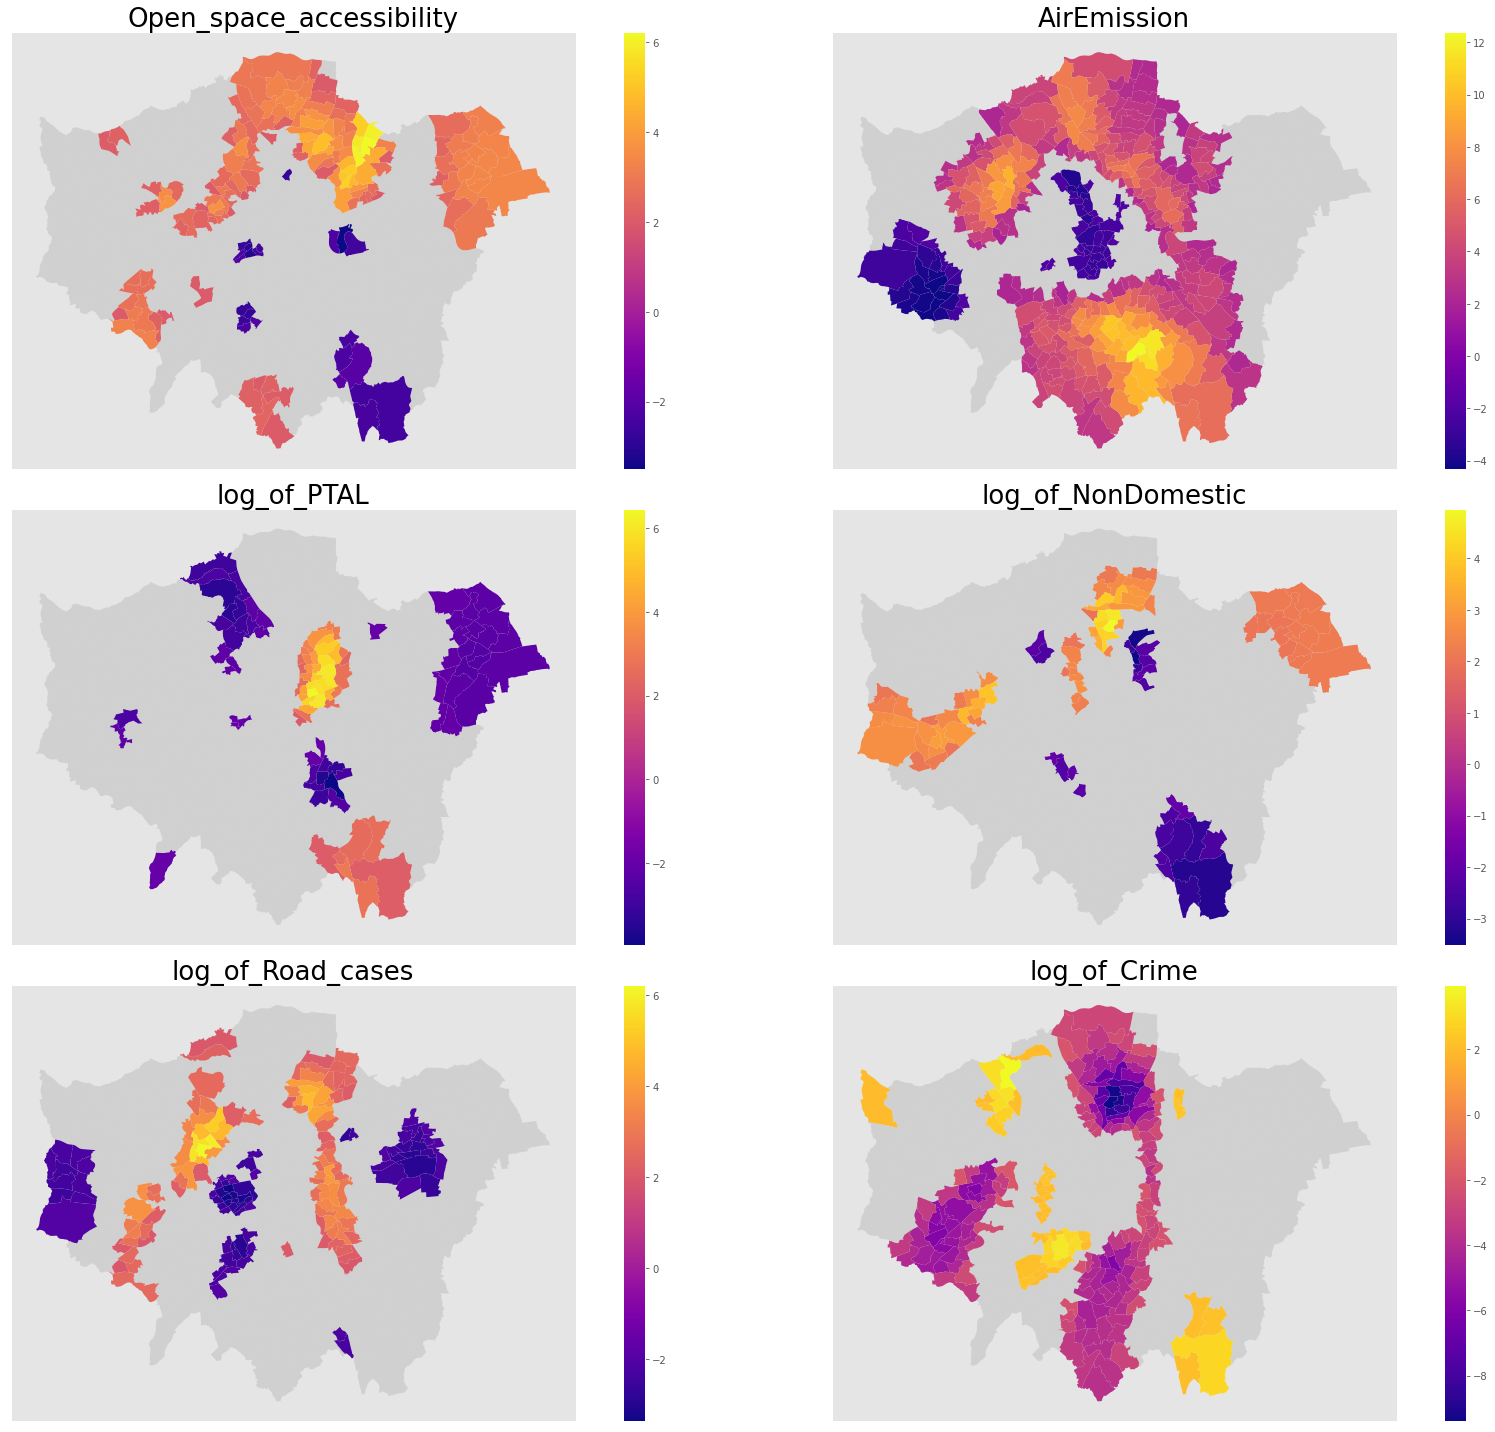

In [274]:
f,ax= plt.subplots(3,2,figsize=(25,20),subplot_kw=dict(aspect='equal'))
ax = ax.flatten()

for i,row in enumerate(filtered_estimates.T):
    if i <6:
        listings_tmp =GEO_final.assign(toplot = filtered_estimates.T[i+1])
        listings_tmp.query('toplot == 0')\
                .sort_values('toplot')\
                .plot(color='grey',marker='.',ax=ax[i],alpha=.2)
        listings_tmp.query('toplot != 0')\
                .sort_values('toplot')\
                .plot('toplot',cmap='plasma',marker='.',ax=ax[i],legend=True)
        ax[i].set_title(['Open_space_accessibility','AirEmission','log_of_PTAL','log_of_NonDomestic','log_of_Road_cases',
                        'log_of_Crime'] [i], fontsize=26)
    
        ax[i].set_xticklabels([]) 
        ax [i] .set_yticklabels([]) 
        ax [i] .set_xticks([]) 
        ax [i] .set_yticks([])
    else:
        break
f.tight_layout()

plt.show()

In [275]:
f.savefig('GWR1.jpg', dpi=300)